In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()
from tqdm.notebook import tqdm
import vector
import itertools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from collections import defaultdict
import seaborn as sns

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xgboost as xgb

In [2]:
tag_ = "XGB"
os.makedirs(tag_, exist_ok=True)
# Load the TensorBoard notebook extension
#%reload_ext tensorboard
#from tensorboard import notebook
#notebook.list() # View open TensorBoard instances
## Control TensorBoard display. If no port is provided, 
## the most recently launched TensorBoard is used
#notebook.display(port=6006, height=1000)

In [3]:
makedir = lambda path: os.makedirs(path, exist_ok=True)
def PlotHistory(history, tag=None):
    """ Takes history from Keras training and makes loss plots (batch and epoch) and learning rate plots """
    #----- Figure -----#
    variables = sorted([key for key in history.epochs.keys() if 'val' not in key and 'val_'+key in history.epochs.keys()])
    variables += ["lr"]
    N = len(variables)
    print(f"variables: {variables}")
    fig, ax = plt.subplots(N,2,figsize=(12.5,N*2),sharex='col')
    plt.subplots_adjust(left    = 0.1,
                        right   = 0.6,
                        top     = 0.9,
                        bottom  = 0.1,
                        hspace  = 0.5,
                        wspace  = 0.4)
    
    #----- Batch Plots -----#
    for i,var in enumerate(variables):
        ax[i,0].plot(history.batches['batch'],history.batches[var],'k')
        ax[i,0].set_title(var)
        ax[i,0].set_xlabel('Batch')
        
    #----- Epoch Plots -----#
    for i,var in enumerate(variables):
        ax[i,1].plot(history.epochs['epoch'],history.epochs[var],label='train')
        if 'val_'+var in history.epochs.keys():
            ax[i,1].plot(history.epochs['epoch'],history.epochs['val_'+var],label='validation')
        ax[i,1].set_title(var)
        ax[i,1].legend()
        ax[i,1].set_xlabel('Epoch')

    png_name = 'Loss_Acc_LR.png'
    makedir(tag_)
    fig.savefig(os.path.join(tag, png_name), dpi=300)
    print('Curves saved as %s'%png_name)
#######################################################

In [4]:
indf = "df_DY.h5"
df = pd.read_hdf(indf)
df

,tau_1_pt,tau_2_pt,jet_1_pt,jet_2_pt,jet_3_pt,jet_4_pt,jet_5_pt,jet_6_pt,tau_1_eta,tau_2_eta,jet_1_eta,jet_2_eta,jet_3_eta,jet_4_eta,jet_5_eta,jet_6_eta,tau_1_phi,tau_2_phi,jet_1_phi,jet_2_phi,jet_3_phi,jet_4_phi,jet_5_phi,jet_6_phi,tau_1_mass,tau_2_mass,jet_1_mass,jet_2_mass,jet_3_mass,jet_4_mass,jet_5_mass,jet_6_mass,tau_1_charge,tau_2_charge,jet_1_charge,jet_2_charge,jet_3_charge,jet_4_charge,jet_5_charge,jet_6_charge,tau_1_dm,tau_2_dm,jet_1_dm,jet_2_dm,jet_3_dm,jet_4_dm,jet_5_dm,jet_6_dm,tau_1_rawIsodR03,tau_2_rawIsodR03,jet_1_rawIsodR03,jet_2_rawIsodR03,jet_3_rawIsodR03,jet_4_rawIsodR03,jet_5_rawIsodR03,jet_6_rawIsodR03,tau_1_rawMVAnewDM2017v2,tau_2_rawMVAnewDM2017v2,jet_1_rawMVAnewDM2017v2,jet_2_rawMVAnewDM2017v2,jet_3_rawMVAnewDM2017v2,jet_4_rawMVAnewDM2017v2,jet_5_rawMVAnewDM2017v2,jet_6_rawMVAnewDM2017v2,tau_1_leadTkPtOverTauPt,tau_2_leadTkPtOverTauPt,jet_1_leadTkPtOverTauPt,jet_2_leadTkPtOverTauPt,jet_3_leadTkPtOverTauPt,jet_4_leadTkPtOverTauPt,jet_5_leadTkPtOverTauPt,jet_6_leadTkPtOverTauPt,met_pt,met_phi,njet,npv,ht,MT_tau1_met,MT_tau2_met,MT_tau1_tau2,MT_total,nu_1_px,nu_2_px,nu_1_py,nu_2_py,nu_1_pz,nu_2_pz,dr_0_1,dr_0_2,dr_0_3,dr_0_4,dr_0_5,dr_0_6,dr_0_7,dr_1_2,dr_1_3,dr_1_4,dr_1_5,dr_1_6,dr_1_7,dr_2_3,dr_2_4,dr_2_5,dr_2_6,dr_2_7,dr_3_4,dr_3_5,dr_3_6,dr_3_7,dr_4_5,dr_4_6,dr_4_7,dr_5_6,dr_5_7,dr_6_7
0,48.033108,28.729235,71.50,31.46875,0.0,0.0,0.0,0.0,-0.382324,0.372437,1.414062,2.055664,0.0,0.0,0.0,0.0,2.180664,0.082062,-2.177246,-1.311768,0.0,0.0,0.0,0.0,0.828125,0.692871,11.546875,5.082031,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594727,0.597656,0.0,0.0,0.0,0.0,0.0,0.0,0.955566,0.982422,0.0,0.0,0.0,0.0,0.0,0.0,0.187500,0.369385,0.0,0.0,0.0,0.0,0.0,0.0,30.271704,0.928711,6.0,13.0,222.343750,44.682153,24.228937,64.419772,82.057560,-5.953388,3.230606,9.619243,0.799751,-4.047748,1.368441,2.230201,2.633190,3.705684,0.0,0.0,0.0,0.0,2.487862,2.18541,0.0,0.0,0.0,0.0,1.077361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40.412121,32.172108,0.00,0.00000,0.0,0.0,0.0,0.0,0.008512,-0.762939,0.000000,0.000000,0.0,0.0,0.0,0.0,2.462402,-0.735107,0.000000,0.000000,0.0,0.0,0.0,0.0,0.139526,0.139526,0.000000,0.000000,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.577148,0.0,0.0,0.0,0.0,0.0,0.0,0.897461,0.640625,0.0,0.0,0.0,0.0,0.0,0.0,0.999512,0.844238,0.0,0.0,0.0,0.0,0.0,0.0,28.568201,0.140839,5.0,23.0,141.125000,62.323393,25.714861,72.086810,98.701406,-0.405411,8.164962,0.562485,-6.651362,0.138355,-8.633410,3.180650,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,33.783928,23.806927,31.75,0.00000,0.0,0.0,0.0,0.0,-0.474121,-0.177216,1.643555,0.000000,0.0,0.0,0.0,0.0,-2.354004,0.656372,-1.490234,0.000000,0.0,0.0,0.0,0.0,0.680176,0.636719,5.054688,0.000000,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.992188,0.952637,0.0,0.0,0.0,0.0,0.0,0.0,0.684082,0.509277,0.0,0.0,0.0,0.0,0.0,0.0,25.996897,1.269043,7.0,24.0,168.289062,57.562388,15.004648,56.598036,82.109108,-15.325022,22.642181,-14.082040,19.965389,-11.028978,-5.049594,3.024982,2.287061,0.000000,0.0,0.0,0.0,0.0,2.814804,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.094788,30.884874,0.00,0.00000,0.0,0.0,0.0,0.0,-0.021152,0.958618,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.012466,3.138184,0.000000,0.000000,0.0,0.0,0.0,0.0,0.914551,0.139526,0.000000,0.000000,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.521484,0.0,0.0,0.0,0.0,0.0,0.0,0.970215,0.979980,0.0,0.0,0.0,0.0,0.0,0.0,0.273926,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,5.806743,1.288086,5.0,15.0,139.437500,17.284804,21.390739,65.844539,71.357071,6.468565,-5.884447,-0.638495,0.791952,-0.330220,6.521297,3.282184,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0

In [5]:
drop_cols_pt  = [f"jet_{i}_pt" for i in range(5,7)]
drop_cols_eta = [f"jet_{i}_eta" for i in range(5,7)]
drop_cols_phi = [f"jet_{i}_phi" for i in range(5,7)]
drop_cols_mass = [f"jet_{i}_mass" for i in range(5,7)]
drop_cols_chr = [f"jet_{i}_charge" for i in range(1,7)]
drop_cols_dm  = [f"jet_{i}_dm" for i in range(1,7)]
drop_cols_iso = [f"jet_{i}_rawIsodR03" for i in range(1,7)]
drop_cols_mva = [f"jet_{i}_rawMVAnewDM2017v2" for i in range(1,7)]
drop_cols_tkpt = [f"jet_{i}_leadTkPtOverTauPt" for i in range(1,7)]
drop_cols_dr = [f"dr_{i}_6" for i in range(6)] + [f"dr_{i}_7" for i in range(7)]

drop_cols = [*drop_cols_pt, *drop_cols_eta, *drop_cols_phi, *drop_cols_mass, 
             *drop_cols_chr, *drop_cols_dm,
             *drop_cols_iso, *drop_cols_mva, *drop_cols_tkpt, *drop_cols_dr]

df = df.drop(columns=drop_cols)
df

,tau_1_pt,tau_2_pt,jet_1_pt,jet_2_pt,jet_3_pt,jet_4_pt,tau_1_eta,tau_2_eta,jet_1_eta,jet_2_eta,jet_3_eta,jet_4_eta,tau_1_phi,tau_2_phi,jet_1_phi,jet_2_phi,jet_3_phi,jet_4_phi,tau_1_mass,tau_2_mass,jet_1_mass,jet_2_mass,jet_3_mass,jet_4_mass,tau_1_charge,tau_2_charge,tau_1_dm,tau_2_dm,tau_1_rawIsodR03,tau_2_rawIsodR03,tau_1_rawMVAnewDM2017v2,tau_2_rawMVAnewDM2017v2,tau_1_leadTkPtOverTauPt,tau_2_leadTkPtOverTauPt,met_pt,met_phi,njet,npv,ht,MT_tau1_met,MT_tau2_met,MT_tau1_tau2,MT_total,nu_1_px,nu_2_px,nu_1_py,nu_2_py,nu_1_pz,nu_2_pz,dr_0_1,dr_0_2,dr_0_3,dr_0_4,dr_0_5,dr_1_2,dr_1_3,dr_1_4,dr_1_5,dr_2_3,dr_2_4,dr_2_5,dr_3_4,dr_3_5,dr_4_5
0,48.033108,28.729235,71.50,31.46875,0.0,0.0,-0.382324,0.372437,1.414062,2.055664,0.0,0.0,2.180664,0.082062,-2.177246,-1.311768,0.0,0.0,0.828125,0.692871,11.546875,5.082031,0.0,0.0,1.0,-1.0,1.0,1.0,0.594727,0.597656,0.955566,0.982422,0.187500,0.369385,30.271704,0.928711,6.0,13.0,222.343750,44.682153,24.228937,64.419772,82.057560,-5.953388,3.230606,9.619243,0.799751,-4.047748,1.368441,2.230201,2.633190,3.705684,0.0,0.0,2.487862,2.18541,0.0,0.0,1.077361,0.0,0.0,0.0,0.0,0.0
1,40.412121,32.172108,0.00,0.00000,0.0,0.0,0.008512,-0.762939,0.000000,0.000000,0.0,0.0,2.462402,-0.735107,0.000000,0.000000,0.0,0.0,0.139526,0.139526,0.000000,0.000000,0.0,0.0,-1.0,1.0,0.0,0.0,0.000000,1.577148,0.897461,0.640625,0.999512,0.844238,28.568201,0.140839,5.0,23.0,141.125000,62.323393,25.714861,72.086810,98.701406,-0.405411,8.164962,0.562485,-6.651362,0.138355,-8.633410,3.180650,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,33.783928,23.806927,31.75,0.00000,0.0,0.0,-0.474121,-0.177216,1.643555,0.000000,0.0,0.0,-2.354004,0.656372,-1.490234,0.000000,0.0,0.0,0.680176,0.636719,5.054688,0.000000,0.0,0.0,1.0,-1.0,1.0,1.0,0.000000,0.000000,0.992188,0.952637,0.684082,0.509277,25.996897,1.269043,7.0,24.0,168.289062,57.562388,15.004648,56.598036,82.109108,-15.325022,22.642181,-14.082040,19.965389,-11.028978,-5.049594,3.024982,2.287061,0.000000,0.0,0.0,2.814804,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,35.094788,30.884874,0.00,0.00000,0.0,0.0,-0.021152,0.958618,0.000000,0.000000,0.0,0.0,-0.012466,3.138184,0.000000,0.000000,0.0,0.0,0.914551,0.139526,0.000000,0.000000,0.0,0.0,-1.0,1.0,1.0,0.0,0.000000,1.521484,0.970215,0.979980,0.273926,1.000000,5.806743,1.288086,5.0,15.0,139.437500,17.284804,21.390739,65.844539,71.357071,6.468565,-5.884447,-0.638495,0.791952,-0.330220,6.521297,3.282184,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,32.348186,21.945780,0.00,0.00000,0.0,0.0,0.109818,1.177979,0.000000,0.000000,0.0,0.0,0.089645,3.110352,0.000000,0.000000,0.0,0.0,0.786133,0.587402,0.000000,0.000000,0.0,0.0,-1.0,1.0,1.0,1.0,0.000000,0.000000,0.903809,-0.102844,0.546875,0.387207,25.342140,-1.991211,4.0,26.0,100.375000,49.396542,26.273004,53.190818,77.198137,10.921062,-9.091042,1.315448,0.221912,0.354554,14.300893,3.204003,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599673,35.871727,20.663029,0.00,0.00000,0.0,0.0,1.241211,-0.591553,0.000000,0.000000,0.0,0.0,-1.740479,-0.439819,0.000000,0.000000,0.0,0.0,1.035156,0.779297,0.000000,0.000000,0.0,0.0,-1.0,1.0,10.0,1.0,0.000000,0.000000,0.988770,0.911621,0.687988,0.155151,35.591686,0.951904,4.0,18.0,119.718750,69.667870,34.768919,32.967082,84.553642,-1.136619,4.849249,-8.801915,-2.245095,13.072798,-2.731749,2.247385,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
599674,39.177204,25.703598,0.00,0.00000,0.0,0.0,0.623169,0.738037,0.000000,0.000000,0.0,0.0,-0.668701,2.477539,0.000000,0.000000,0.0,0.0,0.803223,0.139526,0.000000,0.000000,0.0,0.0,1.0,-1.0,1.0,0.0,0.000000,0.000000,0.988281,0.980957,0.13940

In [6]:
df["tau_1_nc"] = df["tau_2_nc"] = 10
df["tau_1_np"] = df["tau_2_np"] = 10

In [7]:
for i in range(1,3):
    df[f"tau_{i}_nc"] = np.where(df[f"tau_{i}_dm"] == 0, 1, df[f"tau_{i}_nc"])
    df[f"tau_{i}_nc"] = np.where(df[f"tau_{i}_dm"] == 1, 1, df[f"tau_{i}_nc"])
    df[f"tau_{i}_nc"] = np.where(df[f"tau_{i}_dm"] == 2, 1, df[f"tau_{i}_nc"])
    df[f"tau_{i}_nc"] = np.where(df[f"tau_{i}_dm"] == 5, 2, df[f"tau_{i}_nc"])
    df[f"tau_{i}_nc"] = np.where(df[f"tau_{i}_dm"] == 6, 2, df[f"tau_{i}_nc"])
    df[f"tau_{i}_nc"] = np.where(df[f"tau_{i}_dm"] == 7, 2, df[f"tau_{i}_nc"])
    df[f"tau_{i}_nc"] = np.where(df[f"tau_{i}_dm"] == 10, 3, df[f"tau_{i}_nc"])
    df[f"tau_{i}_nc"] = np.where(df[f"tau_{i}_dm"] == 11, 3, df[f"tau_{i}_nc"])

    df[f"tau_{i}_np"] = np.where(df[f"tau_{i}_dm"] == 0, 0, df[f"tau_{i}_np"])
    df[f"tau_{i}_np"] = np.where(df[f"tau_{i}_dm"] == 1, 1, df[f"tau_{i}_np"])
    df[f"tau_{i}_np"] = np.where(df[f"tau_{i}_dm"] == 2, 2, df[f"tau_{i}_np"])
    df[f"tau_{i}_np"] = np.where(df[f"tau_{i}_dm"] == 5, 0, df[f"tau_{i}_np"])
    df[f"tau_{i}_np"] = np.where(df[f"tau_{i}_dm"] == 6, 1, df[f"tau_{i}_np"])
    df[f"tau_{i}_np"] = np.where(df[f"tau_{i}_dm"] == 7, 2, df[f"tau_{i}_np"])
    df[f"tau_{i}_np"] = np.where(df[f"tau_{i}_dm"] == 10, 0, df[f"tau_{i}_np"])
    df[f"tau_{i}_np"] = np.where(df[f"tau_{i}_dm"] == 11, 1, df[f"tau_{i}_np"])


In [8]:
df

,tau_1_pt,tau_2_pt,jet_1_pt,jet_2_pt,jet_3_pt,jet_4_pt,tau_1_eta,tau_2_eta,jet_1_eta,jet_2_eta,jet_3_eta,jet_4_eta,tau_1_phi,tau_2_phi,jet_1_phi,jet_2_phi,jet_3_phi,jet_4_phi,tau_1_mass,tau_2_mass,jet_1_mass,jet_2_mass,jet_3_mass,jet_4_mass,tau_1_charge,tau_2_charge,tau_1_dm,tau_2_dm,tau_1_rawIsodR03,tau_2_rawIsodR03,tau_1_rawMVAnewDM2017v2,tau_2_rawMVAnewDM2017v2,tau_1_leadTkPtOverTauPt,tau_2_leadTkPtOverTauPt,met_pt,met_phi,njet,npv,ht,MT_tau1_met,MT_tau2_met,MT_tau1_tau2,MT_total,nu_1_px,nu_2_px,nu_1_py,nu_2_py,nu_1_pz,nu_2_pz,dr_0_1,dr_0_2,dr_0_3,dr_0_4,dr_0_5,dr_1_2,dr_1_3,dr_1_4,dr_1_5,dr_2_3,dr_2_4,dr_2_5,dr_3_4,dr_3_5,dr_4_5,tau_1_nc,tau_2_nc,tau_1_np,tau_2_np
0,48.033108,28.729235,71.50,31.46875,0.0,0.0,-0.382324,0.372437,1.414062,2.055664,0.0,0.0,2.180664,0.082062,-2.177246,-1.311768,0.0,0.0,0.828125,0.692871,11.546875,5.082031,0.0,0.0,1.0,-1.0,1.0,1.0,0.594727,0.597656,0.955566,0.982422,0.187500,0.369385,30.271704,0.928711,6.0,13.0,222.343750,44.682153,24.228937,64.419772,82.057560,-5.953388,3.230606,9.619243,0.799751,-4.047748,1.368441,2.230201,2.633190,3.705684,0.0,0.0,2.487862,2.18541,0.0,0.0,1.077361,0.0,0.0,0.0,0.0,0.0,1,1,1,1
1,40.412121,32.172108,0.00,0.00000,0.0,0.0,0.008512,-0.762939,0.000000,0.000000,0.0,0.0,2.462402,-0.735107,0.000000,0.000000,0.0,0.0,0.139526,0.139526,0.000000,0.000000,0.0,0.0,-1.0,1.0,0.0,0.0,0.000000,1.577148,0.897461,0.640625,0.999512,0.844238,28.568201,0.140839,5.0,23.0,141.125000,62.323393,25.714861,72.086810,98.701406,-0.405411,8.164962,0.562485,-6.651362,0.138355,-8.633410,3.180650,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0,0
2,33.783928,23.806927,31.75,0.00000,0.0,0.0,-0.474121,-0.177216,1.643555,0.000000,0.0,0.0,-2.354004,0.656372,-1.490234,0.000000,0.0,0.0,0.680176,0.636719,5.054688,0.000000,0.0,0.0,1.0,-1.0,1.0,1.0,0.000000,0.000000,0.992188,0.952637,0.684082,0.509277,25.996897,1.269043,7.0,24.0,168.289062,57.562388,15.004648,56.598036,82.109108,-15.325022,22.642181,-14.082040,19.965389,-11.028978,-5.049594,3.024982,2.287061,0.000000,0.0,0.0,2.814804,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,1,1
3,35.094788,30.884874,0.00,0.00000,0.0,0.0,-0.021152,0.958618,0.000000,0.000000,0.0,0.0,-0.012466,3.138184,0.000000,0.000000,0.0,0.0,0.914551,0.139526,0.000000,0.000000,0.0,0.0,-1.0,1.0,1.0,0.0,0.000000,1.521484,0.970215,0.979980,0.273926,1.000000,5.806743,1.288086,5.0,15.0,139.437500,17.284804,21.390739,65.844539,71.357071,6.468565,-5.884447,-0.638495,0.791952,-0.330220,6.521297,3.282184,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,1,0
4,32.348186,21.945780,0.00,0.00000,0.0,0.0,0.109818,1.177979,0.000000,0.000000,0.0,0.0,0.089645,3.110352,0.000000,0.000000,0.0,0.0,0.786133,0.587402,0.000000,0.000000,0.0,0.0,-1.0,1.0,1.0,1.0,0.000000,0.000000,0.903809,-0.102844,0.546875,0.387207,25.342140,-1.991211,4.0,26.0,100.375000,49.396542,26.273004,53.190818,77.198137,10.921062,-9.091042,1.315448,0.221912,0.354554,14.300893,3.204003,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599673,35.871727,20.663029,0.00,0.00000,0.0,0.0,1.241211,-0.591553,0.000000,0.000000,0.0,0.0,-1.740479,-0.439819,0.000000,0.000000,0.0,0.0,1.035156,0.779297,0.000000,0.000000,0.0,0.0,-1.0,1.0,10.0,1.0,0.000000,0.000000,0.988770,0.911621,0.687988,0.155151,35.591686,0.951904,4.0,18.0,119.718750,69.667870,34.768919,32.967082,84.553642,-1.136619,4.849249,-8.801915,-2.245095,13.072798,-2.731749,2.247385,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3,1,0,1
599674,39.177204,25.703598,0.00,0.00000,0.0,0.0,0.623169,0.738037,0.000000,0.000000,0.0,0.0,-0.668701,2.477539,0.000000,0.000000,0.0,0.0,0.80

In [9]:
df = df.drop(columns=['tau_1_dm', 'tau_2_dm'])

In [10]:
df

,tau_1_pt,tau_2_pt,jet_1_pt,jet_2_pt,jet_3_pt,jet_4_pt,tau_1_eta,tau_2_eta,jet_1_eta,jet_2_eta,jet_3_eta,jet_4_eta,tau_1_phi,tau_2_phi,jet_1_phi,jet_2_phi,jet_3_phi,jet_4_phi,tau_1_mass,tau_2_mass,jet_1_mass,jet_2_mass,jet_3_mass,jet_4_mass,tau_1_charge,tau_2_charge,tau_1_rawIsodR03,tau_2_rawIsodR03,tau_1_rawMVAnewDM2017v2,tau_2_rawMVAnewDM2017v2,tau_1_leadTkPtOverTauPt,tau_2_leadTkPtOverTauPt,met_pt,met_phi,njet,npv,ht,MT_tau1_met,MT_tau2_met,MT_tau1_tau2,MT_total,nu_1_px,nu_2_px,nu_1_py,nu_2_py,nu_1_pz,nu_2_pz,dr_0_1,dr_0_2,dr_0_3,dr_0_4,dr_0_5,dr_1_2,dr_1_3,dr_1_4,dr_1_5,dr_2_3,dr_2_4,dr_2_5,dr_3_4,dr_3_5,dr_4_5,tau_1_nc,tau_2_nc,tau_1_np,tau_2_np
0,48.033108,28.729235,71.50,31.46875,0.0,0.0,-0.382324,0.372437,1.414062,2.055664,0.0,0.0,2.180664,0.082062,-2.177246,-1.311768,0.0,0.0,0.828125,0.692871,11.546875,5.082031,0.0,0.0,1.0,-1.0,0.594727,0.597656,0.955566,0.982422,0.187500,0.369385,30.271704,0.928711,6.0,13.0,222.343750,44.682153,24.228937,64.419772,82.057560,-5.953388,3.230606,9.619243,0.799751,-4.047748,1.368441,2.230201,2.633190,3.705684,0.0,0.0,2.487862,2.18541,0.0,0.0,1.077361,0.0,0.0,0.0,0.0,0.0,1,1,1,1
1,40.412121,32.172108,0.00,0.00000,0.0,0.0,0.008512,-0.762939,0.000000,0.000000,0.0,0.0,2.462402,-0.735107,0.000000,0.000000,0.0,0.0,0.139526,0.139526,0.000000,0.000000,0.0,0.0,-1.0,1.0,0.000000,1.577148,0.897461,0.640625,0.999512,0.844238,28.568201,0.140839,5.0,23.0,141.125000,62.323393,25.714861,72.086810,98.701406,-0.405411,8.164962,0.562485,-6.651362,0.138355,-8.633410,3.180650,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,0,0
2,33.783928,23.806927,31.75,0.00000,0.0,0.0,-0.474121,-0.177216,1.643555,0.000000,0.0,0.0,-2.354004,0.656372,-1.490234,0.000000,0.0,0.0,0.680176,0.636719,5.054688,0.000000,0.0,0.0,1.0,-1.0,0.000000,0.000000,0.992188,0.952637,0.684082,0.509277,25.996897,1.269043,7.0,24.0,168.289062,57.562388,15.004648,56.598036,82.109108,-15.325022,22.642181,-14.082040,19.965389,-11.028978,-5.049594,3.024982,2.287061,0.000000,0.0,0.0,2.814804,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,1,1
3,35.094788,30.884874,0.00,0.00000,0.0,0.0,-0.021152,0.958618,0.000000,0.000000,0.0,0.0,-0.012466,3.138184,0.000000,0.000000,0.0,0.0,0.914551,0.139526,0.000000,0.000000,0.0,0.0,-1.0,1.0,0.000000,1.521484,0.970215,0.979980,0.273926,1.000000,5.806743,1.288086,5.0,15.0,139.437500,17.284804,21.390739,65.844539,71.357071,6.468565,-5.884447,-0.638495,0.791952,-0.330220,6.521297,3.282184,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,1,0
4,32.348186,21.945780,0.00,0.00000,0.0,0.0,0.109818,1.177979,0.000000,0.000000,0.0,0.0,0.089645,3.110352,0.000000,0.000000,0.0,0.0,0.786133,0.587402,0.000000,0.000000,0.0,0.0,-1.0,1.0,0.000000,0.000000,0.903809,-0.102844,0.546875,0.387207,25.342140,-1.991211,4.0,26.0,100.375000,49.396542,26.273004,53.190818,77.198137,10.921062,-9.091042,1.315448,0.221912,0.354554,14.300893,3.204003,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599673,35.871727,20.663029,0.00,0.00000,0.0,0.0,1.241211,-0.591553,0.000000,0.000000,0.0,0.0,-1.740479,-0.439819,0.000000,0.000000,0.0,0.0,1.035156,0.779297,0.000000,0.000000,0.0,0.0,-1.0,1.0,0.000000,0.000000,0.988770,0.911621,0.687988,0.155151,35.591686,0.951904,4.0,18.0,119.718750,69.667870,34.768919,32.967082,84.553642,-1.136619,4.849249,-8.801915,-2.245095,13.072798,-2.731749,2.247385,0.000000,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,3,1,0,1
599674,39.177204,25.703598,0.00,0.00000,0.0,0.0,0.623169,0.738037,0.000000,0.000000,0.0,0.0,-0.668701,2.477539,0.000000,0.000000,0.0,0.0,0.803223,0.139526,0.000000,0.000000,0.0,0.0,1.0,-1.0,0.000000,0.000000,0.988281

In [11]:
df_train, df_test = train_test_split(df,  test_size=0.2,   random_state=42, shuffle=True)

In [12]:
df_train_x = df_train.drop(columns=["nu_1_px", "nu_2_px",
                                    "nu_1_py", "nu_2_py",
                                    "nu_1_pz", "nu_2_pz"])
df_train_y = df_train[["nu_1_px", "nu_1_py", "nu_1_pz", 
                       "nu_2_px", "nu_2_py", "nu_2_pz"]]

df_test_x = df_test.drop(columns=["nu_1_px", "nu_2_px",
                                  "nu_1_py", "nu_2_py",
                                  "nu_1_pz", "nu_2_pz"])
df_test_y = df_test[["nu_1_px", "nu_1_py", "nu_1_pz", 
                     "nu_2_px", "nu_2_py", "nu_2_pz"]]

feats = list(df_train_x.keys())

In [13]:
x_train = df_train_x.to_numpy()
y_train = df_train_y.to_numpy()

x_test = df_test_x.to_numpy()
y_test = df_test_y.to_numpy()

In [14]:
D_train = xgb.DMatrix(x_train, label = y_train, feature_names = feats)
D_test  = xgb.DMatrix(x_test,  label = y_test, feature_names = feats)
watchlist = [(D_train, 'train'), (D_test, 'test')]

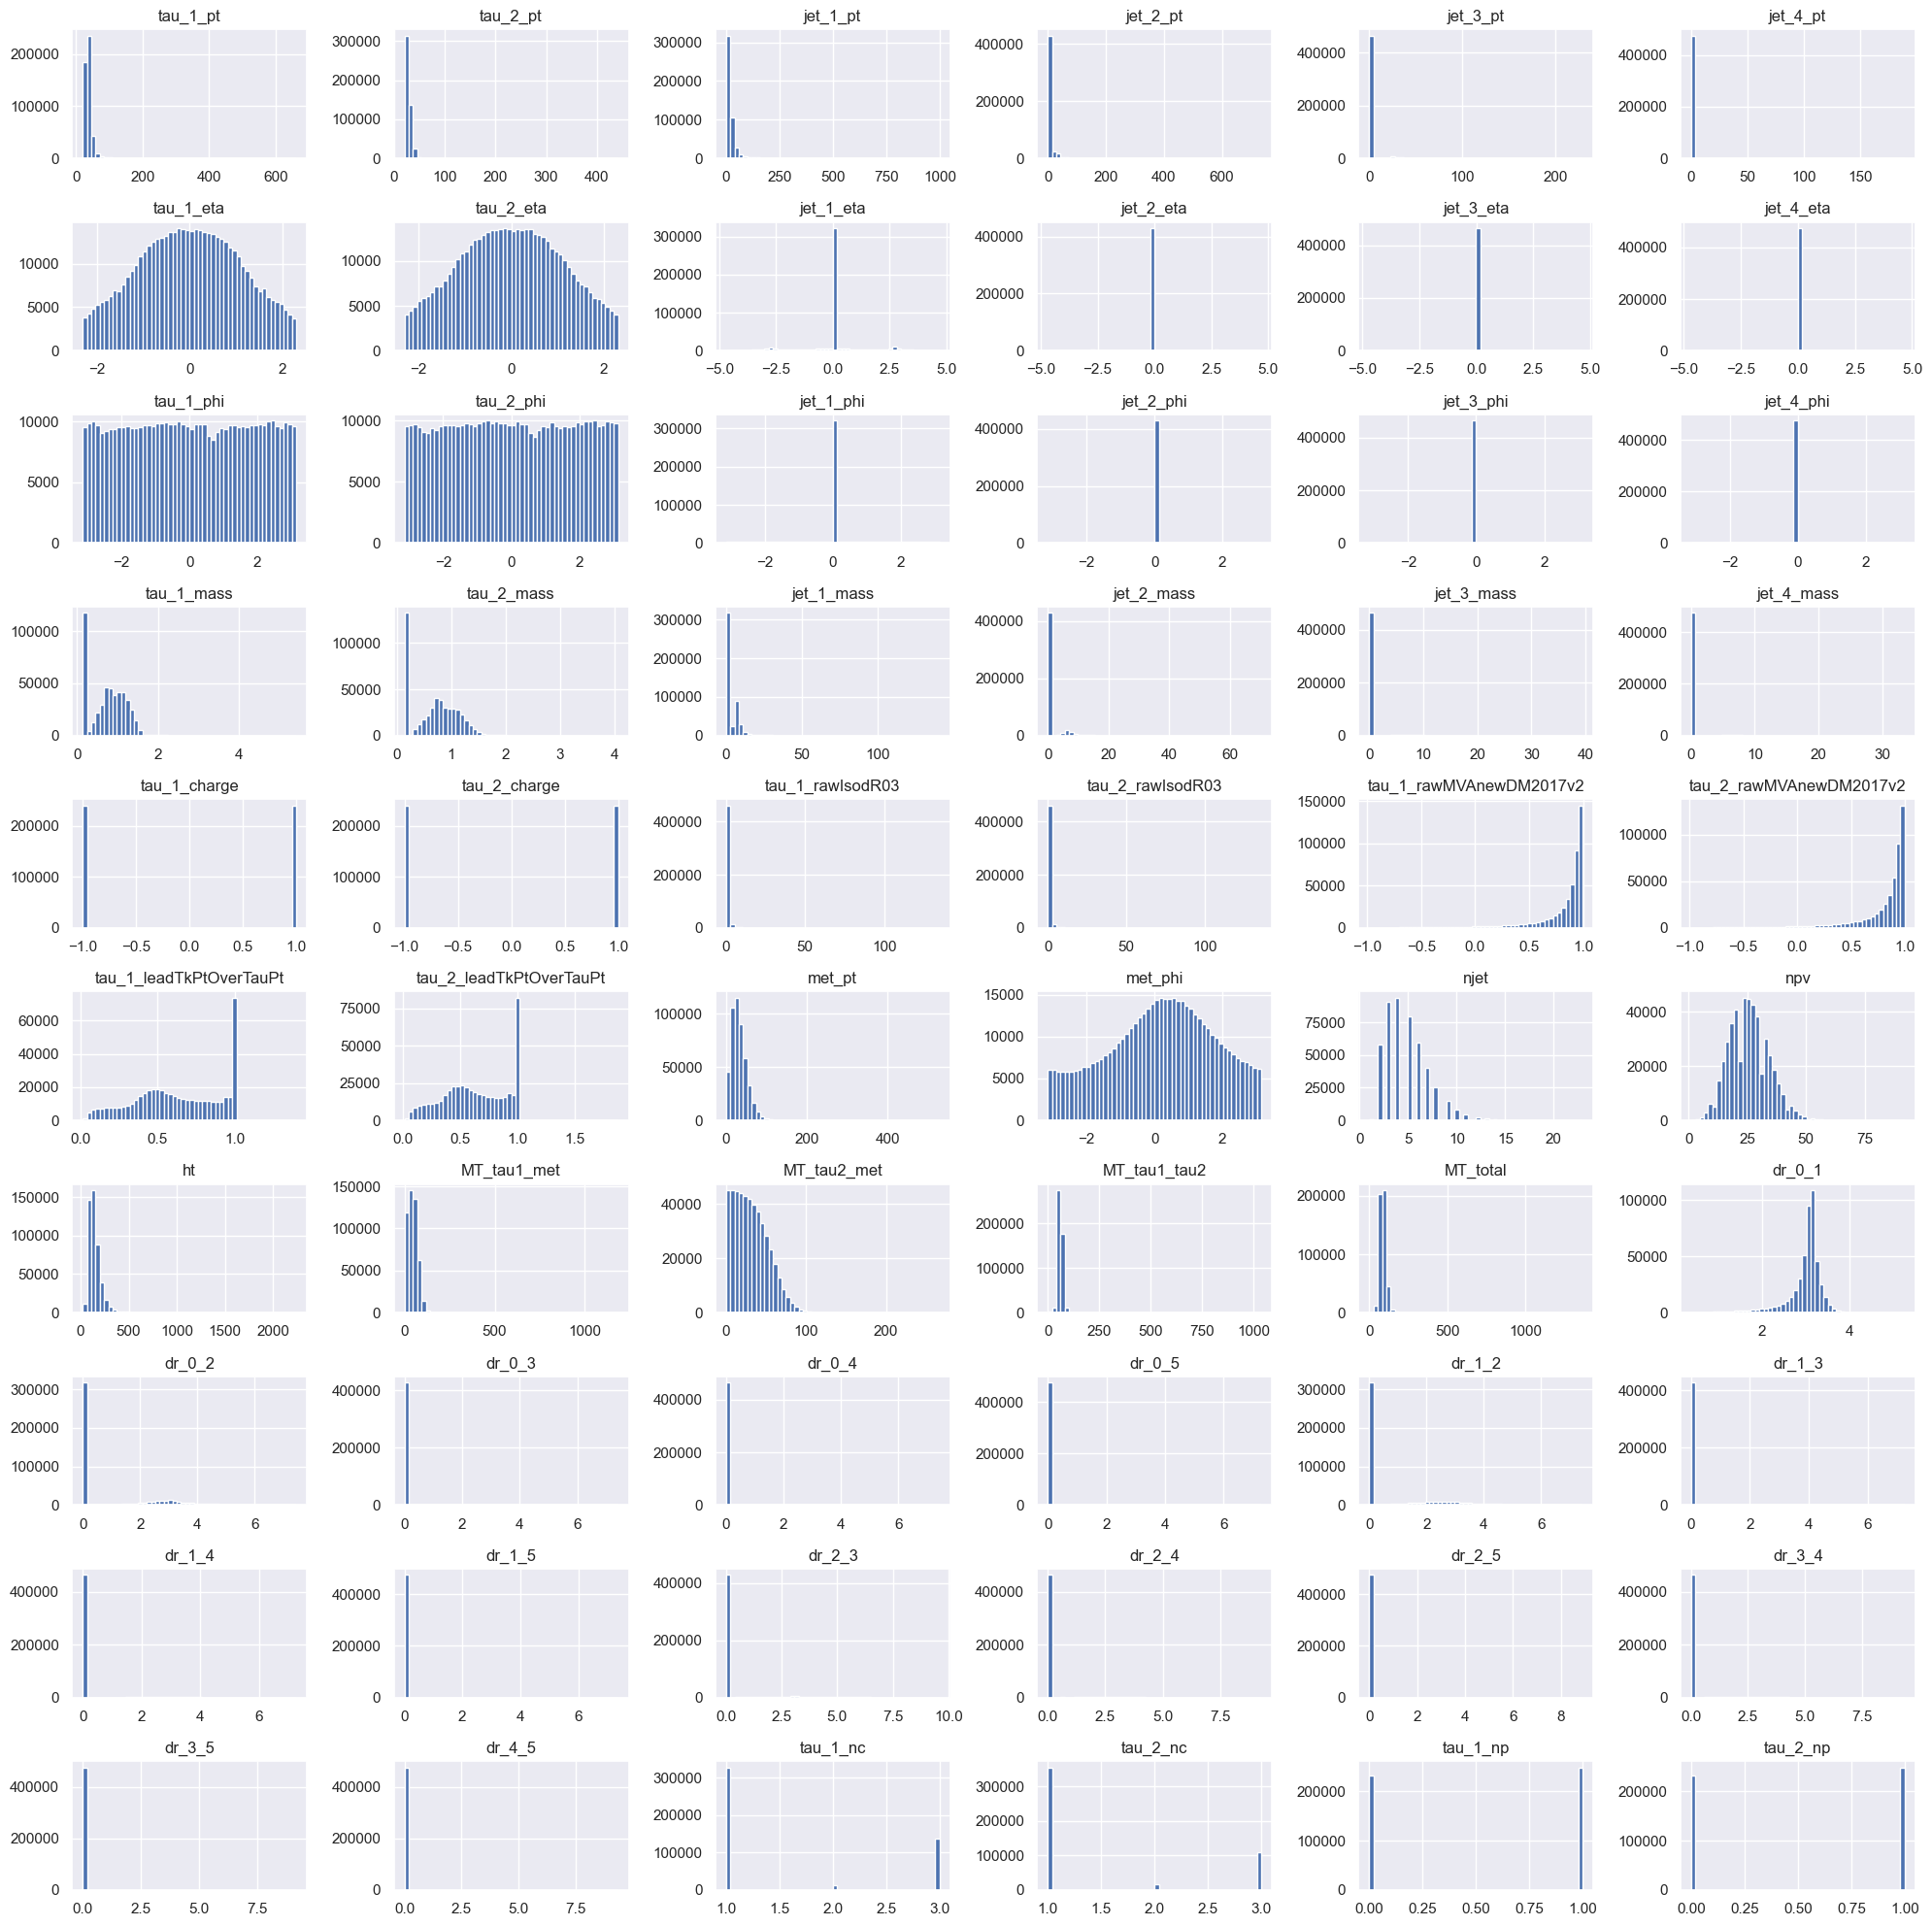

In [15]:
plt.figure(figsize=(20,20))
for idx, key in enumerate(feats):
    idx=idx+1
    ax = plt.subplot(10,6,idx)
    arr = x_train[:,(idx-1):idx].reshape(-1)
    #print(arr)
    ax.hist(arr, 50, range=[np.min(arr), np.max(arr)])
    ax.set_title(f"{key}")
plt.tight_layout()

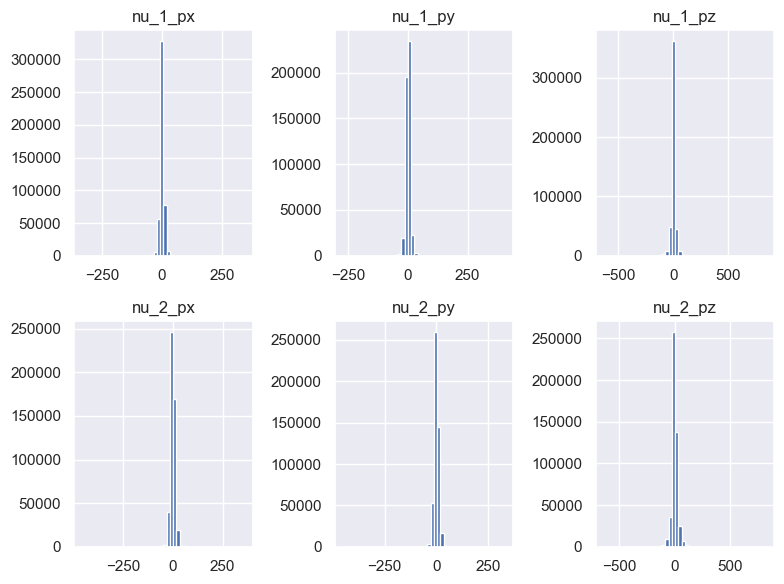

In [16]:
targets = list(df_train_y.keys())
plt.figure(figsize=(8,6))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(2,3,idx)
    arr = y_train[:,(idx-1):idx].reshape(-1)
    #print(arr)
    ax.hist(arr, 50, range=[np.min(arr), np.max(arr)])
    ax.set_title(f"{key}")
plt.tight_layout()

In [17]:
scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test  = scaler.transform(x_test)

In [18]:
x_train

array([[-0.10003479, -0.98348155, -0.49381735, ...,  1.80894616,
         0.96402289, -1.03732843],
       [ 0.21595054,  0.29962803, -0.49381735, ..., -0.57766703,
        -1.03731977,  0.96401484],
       [-0.45982505, -0.43407389, -0.49381735, ...,  1.80894616,
        -1.03731977,  0.96401484],
       ...,
       [-1.02424966, -0.74837685, -0.49381735, ..., -0.57766703,
        -1.03731977,  0.96401484],
       [ 0.88733639,  0.56542198,  0.77852431, ...,  1.80894616,
        -1.03731977, -1.03732843],
       [ 2.75477306, -0.23904773,  1.17179355, ..., -0.57766703,
        -1.03731977,  0.96401484]])

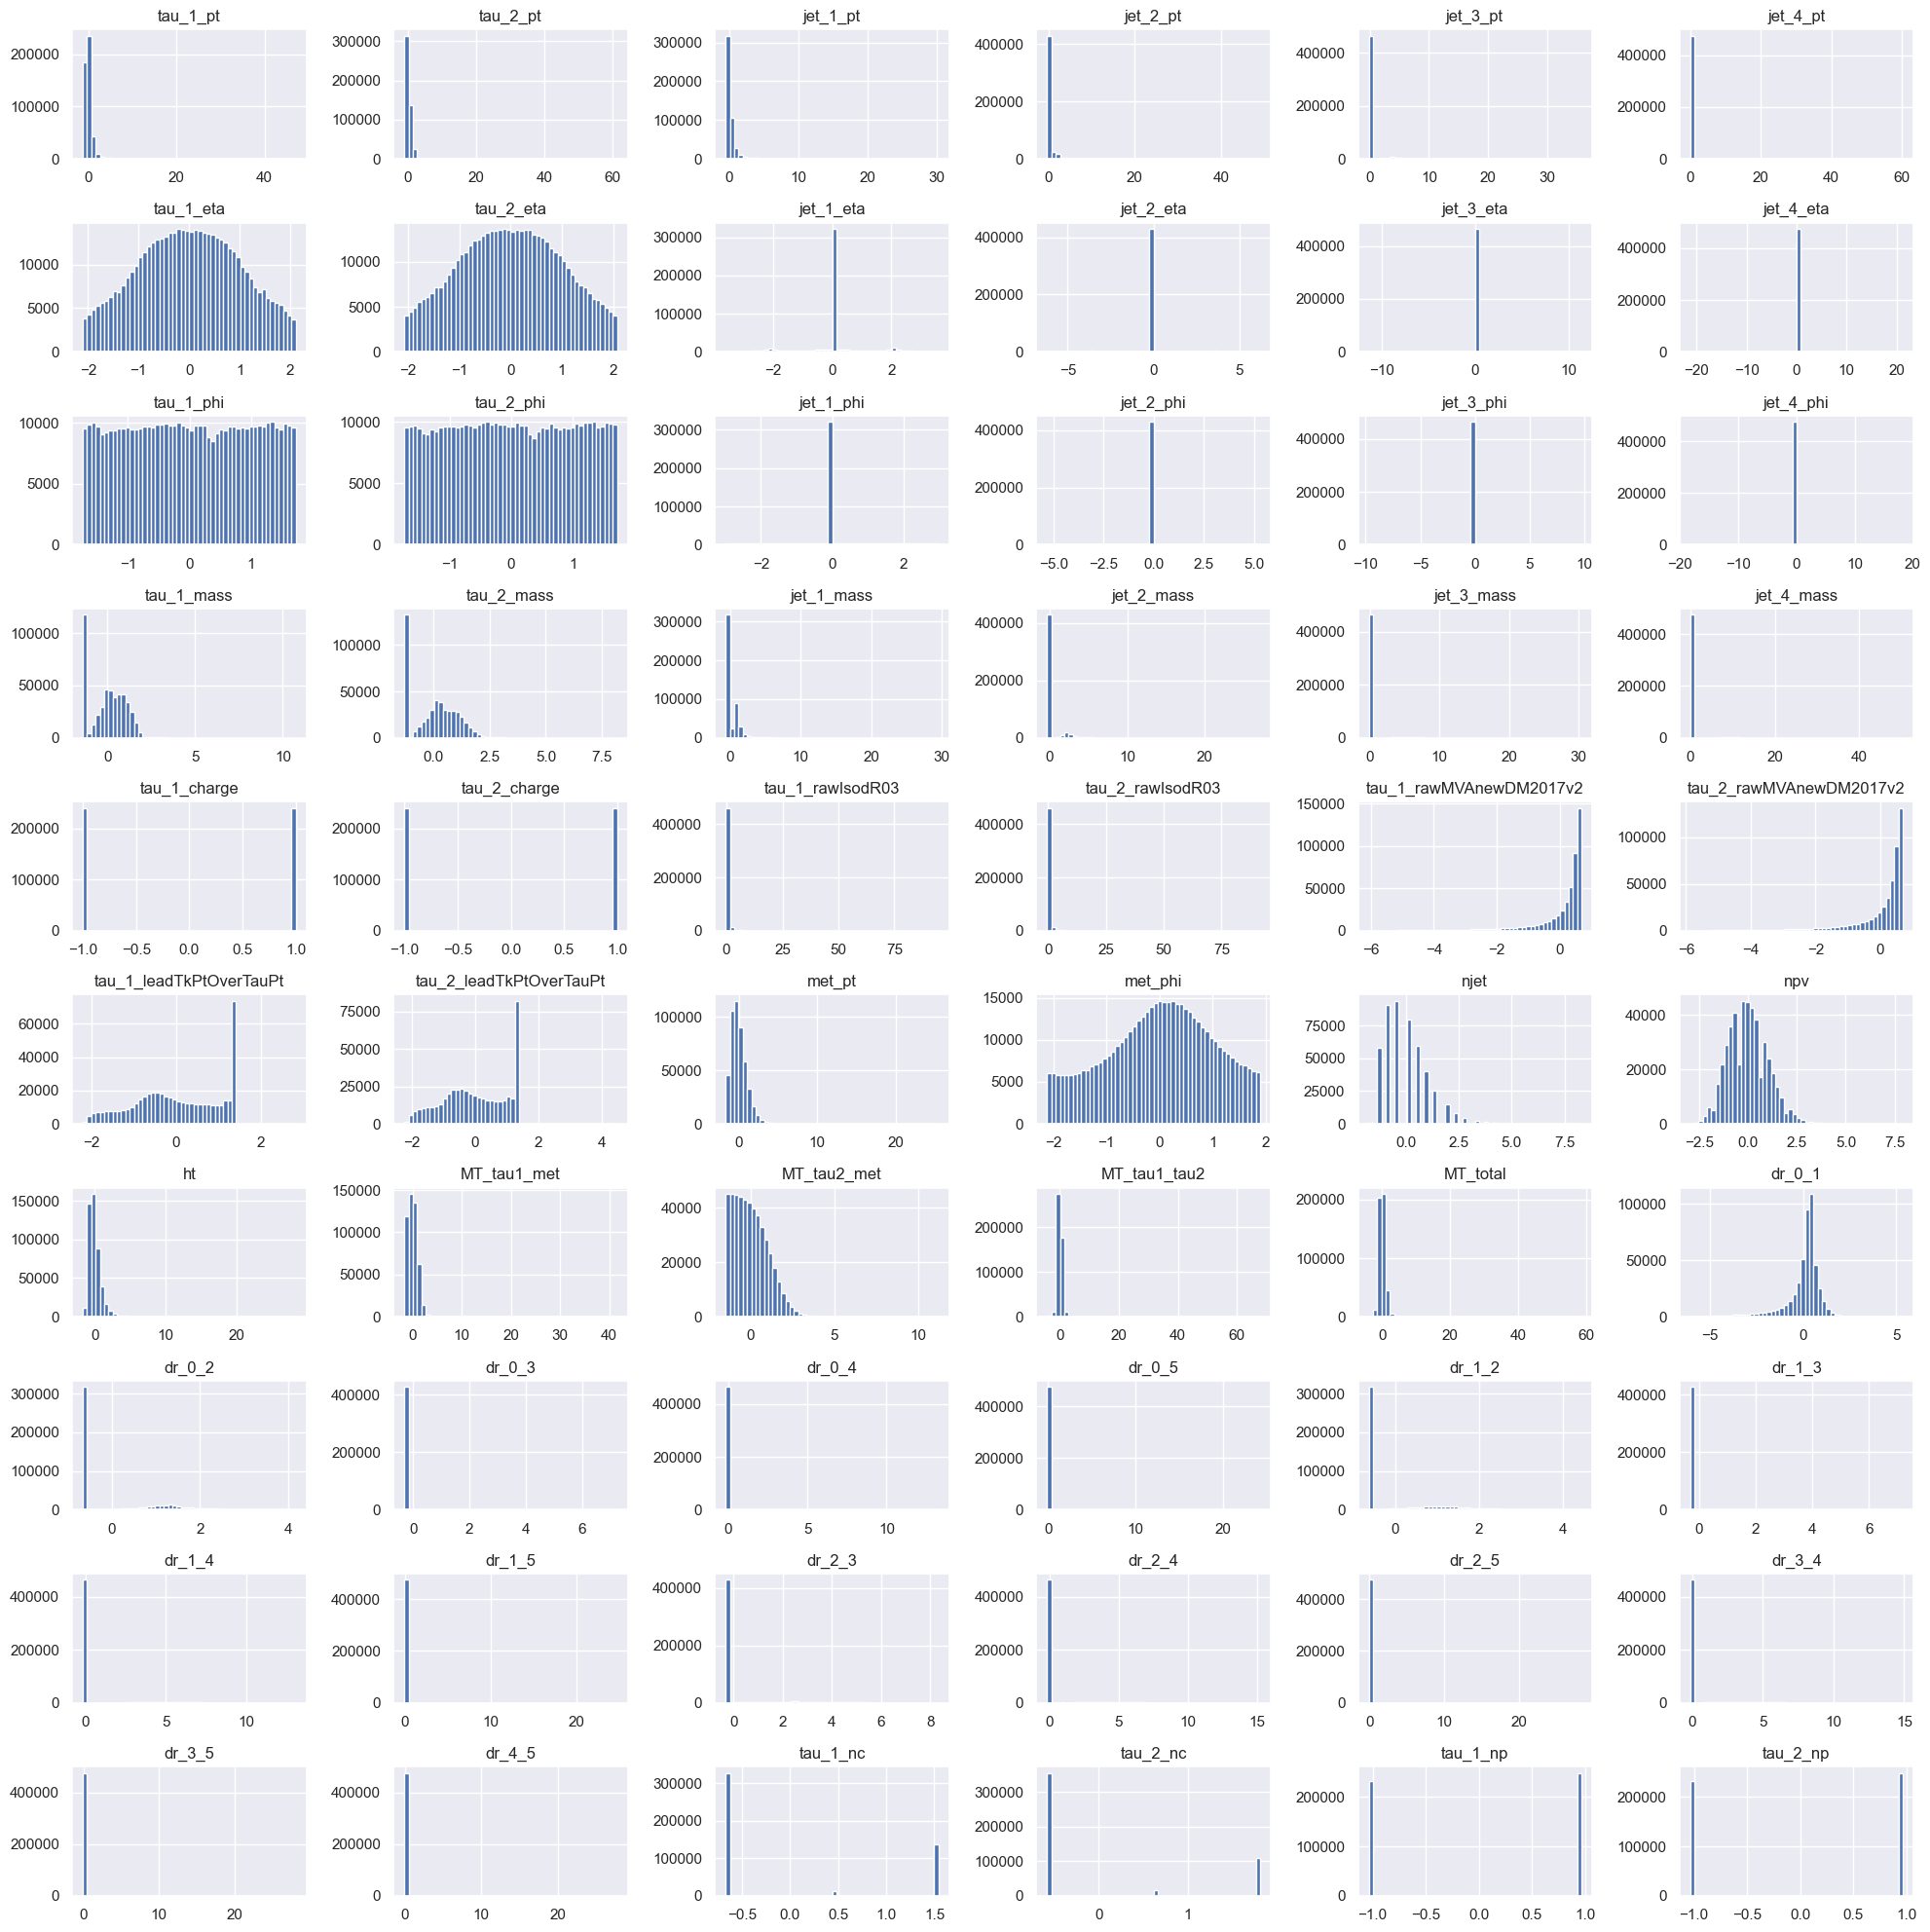

In [19]:
plt.figure(figsize=(20,20))
for idx, key in enumerate(feats):
    idx=idx+1
    ax = plt.subplot(10,6,idx)
    arr = x_train[:,(idx-1):idx].reshape(-1)
    #print(arr)
    ax.hist(arr, 50, range=[np.min(arr), np.max(arr)])
    ax.set_title(f"{key}")
plt.tight_layout()

In [20]:
#############################################
#############################################
prog = dict()

max_iter = 300
eta_min = 0.001
eta_max = 0.5
eta_decay = np.linspace(eta_min, eta_max, max_iter).tolist()
params = {
        "nthread":-1,
        "objective": "reg:squarederror",
        "booster" : "gbtree",
        "eval_metric": ['rmse','mae'], 
        "eta": 0.1,#0.03 #0.01
        "n_estimators": 500,
        #"tree_method": 'exact',
        #"gpu_id" : -1,
        "tree_method": 'auto',
        #"predictor": "gpu_predictor",
        #"updater": "grow_gpu",
        "max_depth": 3,#3 #2
        "subsample": 1,
        "colsample_bytree": 1,
        "silent": 1,
        "min_child_weight": 1
        #"callbacks": [xgb.callback.LearningRateScheduler(eta_decay)]
    }
num_boost_round = 1000
early_stopping_rounds = 10
#############################################
#############################################
model = xgb.train(params, D_train, num_boost_round, watchlist,
                  early_stopping_rounds=early_stopping_rounds, 
                  evals_result=prog,verbose_eval=True)
#############################################
#############################################
best_tree = model.best_iteration
model.save_model(os.path.join(tag_,'XGB_test.json'))
model.save_model(os.path.join(tag_,'XGB_test.model'))
model.dump_model(os.path.join(tag_,'XGB_dump.txt'))


/Users/gsaha/anaconda3/envs/PyTorchEnv/lib/python3.11/site-packages/xgboost/core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/gsaha/anaconda3/envs/PyTorchEnv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:23:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators", "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:15.94459	train-mae:8.61554	test-rmse:15.82650	test-mae:8.62233
[1]	train-rmse:15.15324	train-mae:7.91547	test-rmse:15.02813	test-mae:7.92207
[2]	train-rmse:14.47021	train-mae:7.36203	test-rmse:14.33822	test-mae:7.36802
[3]	train-rmse:13.88123	train-mae:6.92150	test-rmse:13.74243	test-mae:6.92720
[4]	train-rmse:13.37770	train-mae:6.57117	test-rmse:13.23358	test-mae:6.57705
[5]	train-rmse:12.94348	train-mae:6.29014	test-rmse:12.79760	test-mae:6.29613
[6]	train-rmse:12.57415	train-mae:6.07192	test-rmse:12.42541	test-mae:6.07815
[7]	train-rmse:12.25720	train-mae:5.89951	test-rmse:12.10827	test-mae:5.90592
[8]	train-rmse:11.98390	train-mae:5.76112	test-rmse:11.82959	test-mae:5.76734
[9]	train-rmse:11.74779	train-mae:5.64837	test-rmse:11.59100	test-mae:5.65447
[10]	train-rmse:11.53999	train-mae:5.56025	test-rmse:11.38542	test-mae:5.56605
[11]	train-rmse:11.36173	train-mae:5.49346	test-rmse:11.20843	test-mae:5.49933
[12]	train-rmse:11.20977	train-mae:5.44339	test-rmse:11.05709	

[106]	train-rmse:9.24598	train-mae:4.89355	test-rmse:9.21945	test-mae:4.91071
[107]	train-rmse:9.24388	train-mae:4.89314	test-rmse:9.21854	test-mae:4.91040
[108]	train-rmse:9.23665	train-mae:4.89042	test-rmse:9.21302	test-mae:4.90775
[109]	train-rmse:9.23173	train-mae:4.88863	test-rmse:9.20832	test-mae:4.90595
[110]	train-rmse:9.22631	train-mae:4.88524	test-rmse:9.20280	test-mae:4.90256
[111]	train-rmse:9.22425	train-mae:4.88473	test-rmse:9.20160	test-mae:4.90213
[112]	train-rmse:9.22249	train-mae:4.88455	test-rmse:9.20018	test-mae:4.90208
[113]	train-rmse:9.22133	train-mae:4.88426	test-rmse:9.19985	test-mae:4.90187
[114]	train-rmse:9.21870	train-mae:4.88320	test-rmse:9.19769	test-mae:4.90089
[115]	train-rmse:9.21717	train-mae:4.88258	test-rmse:9.19740	test-mae:4.90038
[116]	train-rmse:9.21490	train-mae:4.88194	test-rmse:9.19665	test-mae:4.89987
[117]	train-rmse:9.21383	train-mae:4.88169	test-rmse:9.19653	test-mae:4.89985
[118]	train-rmse:9.21061	train-mae:4.88119	test-rmse:9.19515	tes

[212]	train-rmse:8.91984	train-mae:4.73768	test-rmse:8.99444	test-mae:4.76536
[213]	train-rmse:8.91726	train-mae:4.73664	test-rmse:8.99252	test-mae:4.76440
[214]	train-rmse:8.91428	train-mae:4.73530	test-rmse:8.99071	test-mae:4.76320
[215]	train-rmse:8.91302	train-mae:4.73479	test-rmse:8.99019	test-mae:4.76276
[216]	train-rmse:8.91111	train-mae:4.73346	test-rmse:8.98846	test-mae:4.76141
[217]	train-rmse:8.90958	train-mae:4.73283	test-rmse:8.98770	test-mae:4.76088
[218]	train-rmse:8.90638	train-mae:4.73152	test-rmse:8.98505	test-mae:4.75976
[219]	train-rmse:8.90433	train-mae:4.73131	test-rmse:8.98376	test-mae:4.75968
[220]	train-rmse:8.90202	train-mae:4.73085	test-rmse:8.98222	test-mae:4.75931
[221]	train-rmse:8.90103	train-mae:4.73023	test-rmse:8.98201	test-mae:4.75879
[222]	train-rmse:8.89856	train-mae:4.72698	test-rmse:8.98077	test-mae:4.75562
[223]	train-rmse:8.89580	train-mae:4.72660	test-rmse:8.97917	test-mae:4.75537
[224]	train-rmse:8.89353	train-mae:4.72565	test-rmse:8.97814	tes

[318]	train-rmse:8.71262	train-mae:4.63714	test-rmse:8.86804	test-mae:4.67660
[319]	train-rmse:8.71098	train-mae:4.63625	test-rmse:8.86730	test-mae:4.67580
[320]	train-rmse:8.70927	train-mae:4.63400	test-rmse:8.86582	test-mae:4.67360
[321]	train-rmse:8.70797	train-mae:4.63282	test-rmse:8.86496	test-mae:4.67246
[322]	train-rmse:8.70702	train-mae:4.63204	test-rmse:8.86464	test-mae:4.67173
[323]	train-rmse:8.70629	train-mae:4.63169	test-rmse:8.86448	test-mae:4.67145
[324]	train-rmse:8.70493	train-mae:4.63036	test-rmse:8.86383	test-mae:4.67018
[325]	train-rmse:8.70339	train-mae:4.62891	test-rmse:8.86285	test-mae:4.66880
[326]	train-rmse:8.70229	train-mae:4.62756	test-rmse:8.86201	test-mae:4.66752
[327]	train-rmse:8.70146	train-mae:4.62675	test-rmse:8.86166	test-mae:4.66674
[328]	train-rmse:8.70058	train-mae:4.62608	test-rmse:8.86096	test-mae:4.66607
[329]	train-rmse:8.69958	train-mae:4.62571	test-rmse:8.86057	test-mae:4.66580
[330]	train-rmse:8.69854	train-mae:4.62544	test-rmse:8.86036	tes

[424]	train-rmse:8.56570	train-mae:4.55796	test-rmse:8.77891	test-mae:4.60623
[425]	train-rmse:8.56423	train-mae:4.55732	test-rmse:8.77766	test-mae:4.60571
[426]	train-rmse:8.56314	train-mae:4.55661	test-rmse:8.77722	test-mae:4.60506
[427]	train-rmse:8.56230	train-mae:4.55656	test-rmse:8.77731	test-mae:4.60512
[428]	train-rmse:8.56131	train-mae:4.55611	test-rmse:8.77708	test-mae:4.60474
[429]	train-rmse:8.56075	train-mae:4.55599	test-rmse:8.77690	test-mae:4.60472
[430]	train-rmse:8.55918	train-mae:4.55550	test-rmse:8.77555	test-mae:4.60433
[431]	train-rmse:8.55789	train-mae:4.55484	test-rmse:8.77441	test-mae:4.60374
[432]	train-rmse:8.55696	train-mae:4.55463	test-rmse:8.77378	test-mae:4.60361
[433]	train-rmse:8.55571	train-mae:4.55402	test-rmse:8.77299	test-mae:4.60305
[434]	train-rmse:8.55448	train-mae:4.55373	test-rmse:8.77250	test-mae:4.60288
[435]	train-rmse:8.55377	train-mae:4.55306	test-rmse:8.77189	test-mae:4.60227
[436]	train-rmse:8.55203	train-mae:4.55257	test-rmse:8.77055	tes

[530]	train-rmse:8.45249	train-mae:4.50855	test-rmse:8.71628	test-mae:4.56528
[531]	train-rmse:8.45174	train-mae:4.50838	test-rmse:8.71619	test-mae:4.56521
[532]	train-rmse:8.45098	train-mae:4.50822	test-rmse:8.71611	test-mae:4.56517
[533]	train-rmse:8.45064	train-mae:4.50814	test-rmse:8.71621	test-mae:4.56518
[534]	train-rmse:8.44973	train-mae:4.50763	test-rmse:8.71562	test-mae:4.56472
[535]	train-rmse:8.44888	train-mae:4.50717	test-rmse:8.71567	test-mae:4.56436
[536]	train-rmse:8.44806	train-mae:4.50658	test-rmse:8.71522	test-mae:4.56387
[537]	train-rmse:8.44753	train-mae:4.50636	test-rmse:8.71515	test-mae:4.56374
[538]	train-rmse:8.44660	train-mae:4.50592	test-rmse:8.71447	test-mae:4.56334
[539]	train-rmse:8.44582	train-mae:4.50519	test-rmse:8.71399	test-mae:4.56269
[540]	train-rmse:8.44414	train-mae:4.50414	test-rmse:8.71254	test-mae:4.56170
[541]	train-rmse:8.44331	train-mae:4.50370	test-rmse:8.71189	test-mae:4.56126
[542]	train-rmse:8.44267	train-mae:4.50336	test-rmse:8.71170	tes

[636]	train-rmse:8.36839	train-mae:4.47069	test-rmse:8.68296	test-mae:4.53603
[637]	train-rmse:8.36714	train-mae:4.47001	test-rmse:8.68239	test-mae:4.53546
[638]	train-rmse:8.36676	train-mae:4.46985	test-rmse:8.68235	test-mae:4.53538
[639]	train-rmse:8.36622	train-mae:4.46972	test-rmse:8.68246	test-mae:4.53534
[640]	train-rmse:8.36564	train-mae:4.46943	test-rmse:8.68195	test-mae:4.53514
[641]	train-rmse:8.36511	train-mae:4.46927	test-rmse:8.68228	test-mae:4.53512
[642]	train-rmse:8.36462	train-mae:4.46914	test-rmse:8.68226	test-mae:4.53506
[643]	train-rmse:8.36362	train-mae:4.46878	test-rmse:8.68126	test-mae:4.53473
[644]	train-rmse:8.36305	train-mae:4.46870	test-rmse:8.68134	test-mae:4.53473
[645]	train-rmse:8.36242	train-mae:4.46846	test-rmse:8.68134	test-mae:4.53462
[646]	train-rmse:8.36199	train-mae:4.46839	test-rmse:8.68128	test-mae:4.53463
[647]	train-rmse:8.36163	train-mae:4.46836	test-rmse:8.68119	test-mae:4.53468
[648]	train-rmse:8.36115	train-mae:4.46828	test-rmse:8.68142	tes

[742]	train-rmse:8.30208	train-mae:4.44826	test-rmse:8.66349	test-mae:4.52209
[743]	train-rmse:8.30154	train-mae:4.44790	test-rmse:8.66330	test-mae:4.52174
[744]	train-rmse:8.30113	train-mae:4.44777	test-rmse:8.66316	test-mae:4.52165
[745]	train-rmse:8.30078	train-mae:4.44757	test-rmse:8.66297	test-mae:4.52152
[746]	train-rmse:8.30053	train-mae:4.44747	test-rmse:8.66296	test-mae:4.52147
[747]	train-rmse:8.30013	train-mae:4.44746	test-rmse:8.66267	test-mae:4.52151
[748]	train-rmse:8.29941	train-mae:4.44720	test-rmse:8.66240	test-mae:4.52128
[749]	train-rmse:8.29830	train-mae:4.44670	test-rmse:8.66202	test-mae:4.52089
[750]	train-rmse:8.29789	train-mae:4.44656	test-rmse:8.66188	test-mae:4.52080
[751]	train-rmse:8.29717	train-mae:4.44631	test-rmse:8.66157	test-mae:4.52063
[752]	train-rmse:8.29661	train-mae:4.44617	test-rmse:8.66139	test-mae:4.52057
[753]	train-rmse:8.29622	train-mae:4.44608	test-rmse:8.66120	test-mae:4.52051
[754]	train-rmse:8.29579	train-mae:4.44570	test-rmse:8.66091	tes

[848]	train-rmse:8.23678	train-mae:4.41868	test-rmse:8.63450	test-mae:4.50025
[849]	train-rmse:8.23639	train-mae:4.41845	test-rmse:8.63447	test-mae:4.50009
[850]	train-rmse:8.23595	train-mae:4.41833	test-rmse:8.63439	test-mae:4.50006
[851]	train-rmse:8.23551	train-mae:4.41821	test-rmse:8.63447	test-mae:4.50007
[852]	train-rmse:8.23511	train-mae:4.41813	test-rmse:8.63442	test-mae:4.50005
[853]	train-rmse:8.23479	train-mae:4.41803	test-rmse:8.63447	test-mae:4.50005
[854]	train-rmse:8.23407	train-mae:4.41772	test-rmse:8.63410	test-mae:4.49983
[855]	train-rmse:8.23338	train-mae:4.41708	test-rmse:8.63395	test-mae:4.49928
[856]	train-rmse:8.23217	train-mae:4.41644	test-rmse:8.63284	test-mae:4.49870
[857]	train-rmse:8.23142	train-mae:4.41614	test-rmse:8.63254	test-mae:4.49846
[858]	train-rmse:8.23101	train-mae:4.41606	test-rmse:8.63262	test-mae:4.49849
[859]	train-rmse:8.23036	train-mae:4.41591	test-rmse:8.63189	test-mae:4.49835
[860]	train-rmse:8.22989	train-mae:4.41578	test-rmse:8.63167	tes

[954]	train-rmse:8.16998	train-mae:4.39158	test-rmse:8.60254	test-mae:4.48060
[955]	train-rmse:8.16943	train-mae:4.39142	test-rmse:8.60222	test-mae:4.48043
[956]	train-rmse:8.16892	train-mae:4.39127	test-rmse:8.60213	test-mae:4.48038
[957]	train-rmse:8.16783	train-mae:4.39093	test-rmse:8.60116	test-mae:4.48007
[958]	train-rmse:8.16748	train-mae:4.39084	test-rmse:8.60108	test-mae:4.48005
[959]	train-rmse:8.16705	train-mae:4.39078	test-rmse:8.60126	test-mae:4.48010
[960]	train-rmse:8.16644	train-mae:4.39068	test-rmse:8.60129	test-mae:4.48008
[961]	train-rmse:8.16604	train-mae:4.39059	test-rmse:8.60123	test-mae:4.48003
[962]	train-rmse:8.16557	train-mae:4.39024	test-rmse:8.60112	test-mae:4.47980
[963]	train-rmse:8.16517	train-mae:4.39004	test-rmse:8.60108	test-mae:4.47967
[964]	train-rmse:8.16458	train-mae:4.38995	test-rmse:8.60090	test-mae:4.47967
[965]	train-rmse:8.16419	train-mae:4.38979	test-rmse:8.60098	test-mae:4.47962
[966]	train-rmse:8.16369	train-mae:4.38966	test-rmse:8.60109	tes

/Users/gsaha/anaconda3/envs/PyTorchEnv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [19:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


TypeError: Booster.predict() got an unexpected keyword argument 'ntree_limit'

[[ -2.0770426   13.64037     18.820776     1.4955918  -11.400725
    2.6652029 ]
 [  4.8120084   -0.7362184   10.003559   -10.4947195   -0.8242571
    5.1667333 ]
 [  5.6763787    1.1850662   -7.492899    -9.907953    -0.98586625
   -3.1582432 ]
 ...
 [ -2.835281    -9.186544     6.6805134    4.267099    12.095203
   17.274708  ]
 [ -4.151115     1.3257565    0.39079532   7.2915015   -4.8229766
   24.654516  ]
 [ 10.209438    11.179335   -61.404427   -16.167603   -15.209126
  -14.698423  ]]


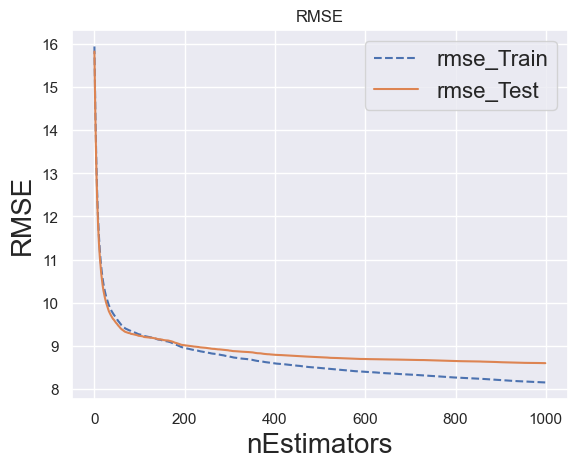

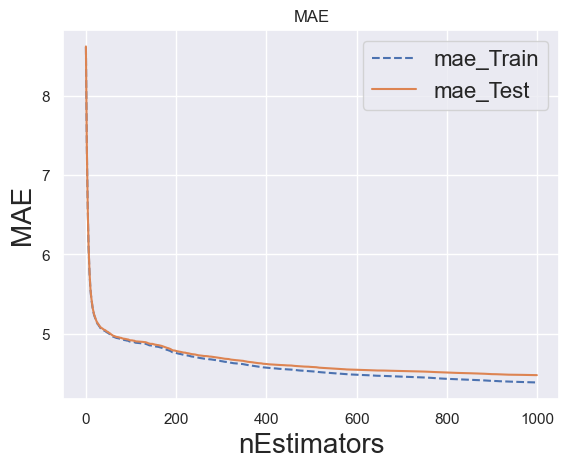

Best score : 4.476191334660336, Best iteration : 999


<Figure size 640x480 with 0 Axes>

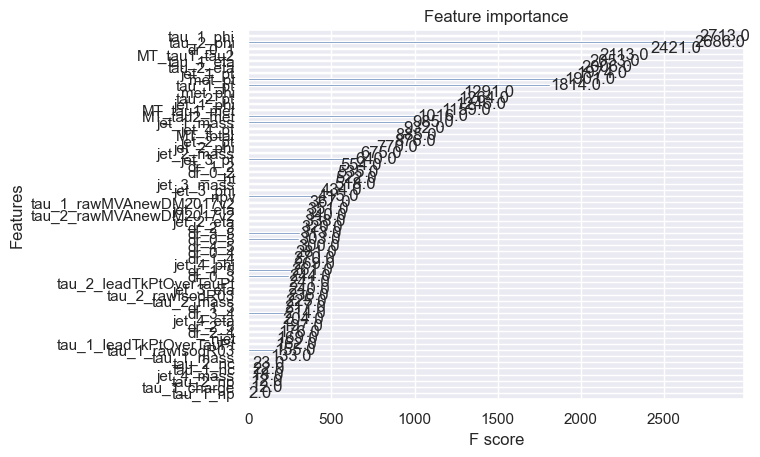

In [21]:
#############################################
#############################################
preds_train = model.predict(D_train)
preds = model.predict(D_test)
print(preds)
#############################################
#############################################
#result = model.evals_result()
prog['train']['rmse']
plt.plot(prog['train']['rmse'], linestyle='dashed',label='rmse_Train')
plt.plot(prog['test']['rmse'], linestyle='solid', label='rmse_Test')
plt.title('RMSE')
plt.legend(loc="upper right", fontsize=16)
plt.xlabel('nEstimators', size=20)
plt.ylabel('RMSE', size=20)
plt.savefig(os.path.join(tag_,'RMSE.png'),dpi=300)
plt.show()
plt.clf()

plt.plot(prog['train']['mae'], linestyle='dashed',label='mae_Train')
plt.plot(prog['test']['mae'], linestyle='solid', label='mae_Test')
plt.title('MAE')
plt.legend(loc="upper right", fontsize=16)
plt.xlabel('nEstimators', size=20)
plt.ylabel('MAE', size=20)
plt.savefig(os.path.join(tag_,'MAE.png'),dpi=300)
plt.show()
plt.clf()

print(f'Best score : {model.best_score}, Best iteration : {model.best_iteration}')

impplot = xgb.plot_importance(model)
plt.savefig(os.path.join(tag_,'feature_importance.png'), dpi=300)

In [23]:
target_reg_val_train   = model.predict(D_train)
target_val_train = y_train
target_reg_val_test    = model.predict(D_test)
target_val_test  = y_test

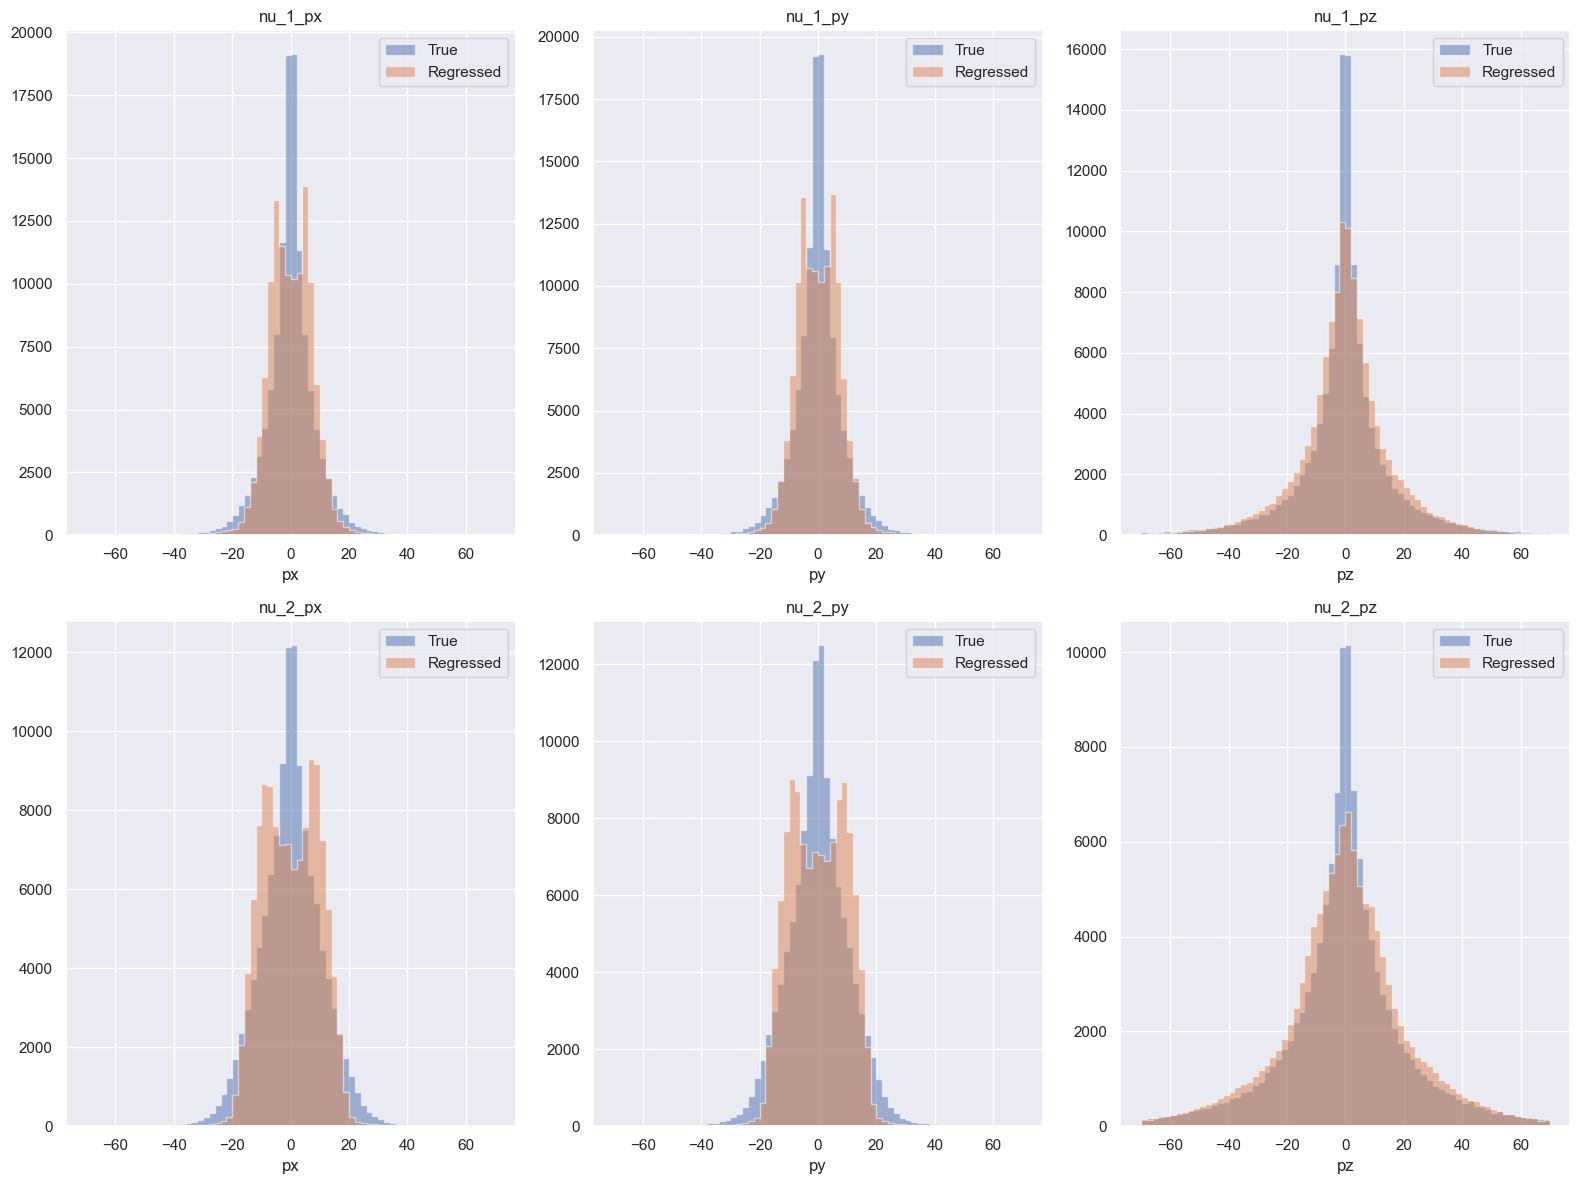

In [24]:
plt.figure(figsize=(16,12))
for idx, key in enumerate(targets):
    idx=idx+1
    ax = plt.subplot(2,3,idx)
    arr_true = target_val_test[:,(idx-1):idx].reshape(-1)
    arr_pred = target_reg_val_test[:,(idx-1):idx].reshape(-1)
    
    #print(arr)
    ax.hist(arr_true, 70, range=[-70.0, 70.0], histtype="stepfilled", alpha=0.5, label='True')
    ax.hist(arr_pred, 70, range=[-70.0, 70.0], histtype="stepfilled", alpha=0.5, label='Regressed')
    ax.set_title(f"{key}")
    ax.set_xlabel(f"""{key.split('_')[-1]}""")
    ax.legend()
plt.tight_layout()
plt.savefig(os.path.join(tag_,'output.png'), dpi=300)

## Evaluate Feature importance 

## correlation 

In [ ]:
corrlMatrix = df_train_x.corr()
plt.figure(figsize=(15,12.5))
sns.heatmap(corrlMatrix, cmap='YlGnBu', annot=False)
plt.title('Correlation Matrix')
plt.savefig(os.path.join(tag_,'Corr_matrix_signal.png'), dpi=300)
plt.show()